# Capstone Project - Car Accident Severity
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology & Analysis](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#results)

## Introduction: Business Problem <a name="introduction"></a>

In this project I will try to make a model to predict the severity of the car accidents. Specifically, this report will be targeted to the Government of the cities, Police departments, road authorities and insurance companies among others.
One of the most important factors indicating the development of a city is the state of its road network. A city that has a transit system in good condition, safe and well connected translates into a better quality of life for its inhabitants. 
Therefore governments invest a large part of their budget in maintaining and improving the road network. 

One of the main consequences of poor traffic management is an increase in the number of accidents that occur. This increase becomes a problem, since it not only translates into a health issue for those injured, but also generates an expense for society in terms of both money and human resources.


## Data <a name="data"></a>


After analyzing various database sources, I chose the "Data Collision" dataset provided by the course. Compared with the other data, these, in addition to being more up-to-date, covered a greater amount of time.

This chosen database contains 38 variables and 194,673 recorded accidents. Of these variables, I consider that the most relevant would be

* Person Count
* Light Condition
* Address Type
* Weather
* Collision Type
* Speeding
* Road Condition

In addition to this, the database has my objective variable "Severity Code" that gives information about the severity of the accident and that I will use to check the validity of the model. In this particular case, the variable can take the values 1 (Property Damage) or 2 (Injury). 



Let's import all the libraries needed to develop the model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import pearsonr  as pr
import seaborn as sns
from matplotlib import pyplot
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import classification_report
import itertools
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

Let's import the dataset and load it as a DataFrame

In [2]:
dataset= pd.read_csv('https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv')

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


From now on, several times I am going to run the code ".head()". That it is to see the first 5 rows of the dataframe with the labels on it.

In [3]:
dataset.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


I will define my new dataframe "acc_var" with only the variables that I think are relevant to my model.

In [4]:
acc_var= dataset[['SEVERITYCODE','ADDRTYPE','COLLISIONTYPE','PERSONCOUNT','WEATHER','ROADCOND','LIGHTCOND','SPEEDING']]

Let's see if there are some nulls in my dataframe

In [5]:
missing_data = acc_var.isnull()
missing_data.head(5)

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,WEATHER,ROADCOND,LIGHTCOND,SPEEDING
0,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,True


In [6]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")    

SEVERITYCODE
False    194673
Name: SEVERITYCODE, dtype: int64

ADDRTYPE
False    192747
True       1926
Name: ADDRTYPE, dtype: int64

COLLISIONTYPE
False    189769
True       4904
Name: COLLISIONTYPE, dtype: int64

PERSONCOUNT
False    194673
Name: PERSONCOUNT, dtype: int64

WEATHER
False    189592
True       5081
Name: WEATHER, dtype: int64

ROADCOND
False    189661
True       5012
Name: ROADCOND, dtype: int64

LIGHTCOND
False    189503
True       5170
Name: LIGHTCOND, dtype: int64

SPEEDING
True     185340
False      9333
Name: SPEEDING, dtype: int64



Let's raplace de null values in the columns "Speeding" for value "N".

In [7]:
acc_var['SPEEDING'].replace(np.nan,'N', inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


The amount of rows with null values it is not significant in comparison with the total amount of records of this dataset. Also, as most of the variables are categorical, it is not that easy to replace de null values with the mean or the model,so I will proceed to drop every row with null values.

In [8]:
acc_var.dropna(axis=0 , inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
acc_var.reset_index(drop=True, inplace=True)

Let's see some basic characteristis about the dataset as how many rows, and columns, some descriptive statistics about quantitative variables, etc.

In [10]:
acc_var.shape

(187504, 8)

In [11]:
acc_var.describe(include='all')

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,WEATHER,ROADCOND,LIGHTCOND,SPEEDING
count,187504.000000,187504,187504,187504.000000,187504,187504,187504,187504
unique,NaN,3,10,NaN,11,9,9,2
top,NaN,Block,Parked Car,NaN,Clear,Dry,Daylight,N
freq,NaN,123315,46679,NaN,110493,123730,115395,178239
mean,1.303300,NaN,NaN,2.463515,NaN,NaN,NaN,NaN
std,0.459685,NaN,NaN,1.360033,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
25%,1.000000,NaN,NaN,2.000000,NaN,NaN,NaN,NaN
50%,1.000000,NaN,NaN,2.000000,NaN,NaN,NaN,NaN
75%,2.000000,NaN,NaN,3.000000,NaN,NaN,NaN,NaN


In [12]:
acc_var.dtypes

SEVERITYCODE      int64
ADDRTYPE         object
COLLISIONTYPE    object
PERSONCOUNT       int64
WEATHER          object
ROADCOND         object
LIGHTCOND        object
SPEEDING         object
dtype: object

Looking good! I have cleaned my dataset. Now I am going to analyze my variables and test the the relevance on predicting my target value "SEVERITYCODE" 

## Methodology & Analysis <a name="Methodology"></a>

In [13]:
acc_var_2= acc_var.groupby(["ADDRTYPE", "SEVERITYCODE"])["ADDRTYPE"].count().reset_index(name="COUNT")
acc_var_2

,ADDRTYPE,SEVERITYCODE,COUNT
0,Alley,1,662
1,Alley,2,80
2,Block,1,93888
3,Block,2,29427
4,Intersection,1,36084
5,Intersection,2,27363


<AxesSubplot:xlabel='SEVERITYCODE'>

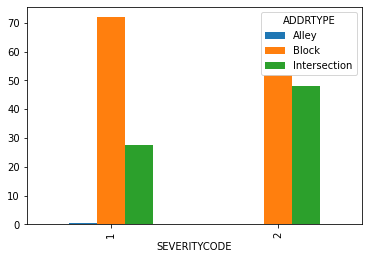

In [14]:
pd.crosstab(index=acc_var['SEVERITYCODE'],
           columns= acc_var['ADDRTYPE']).apply(lambda r: r/r.sum()*100, axis=1).plot(kind='bar')

In [82]:
Weather_test= acc_var.groupby(["WEATHER", "SEVERITYCODE"])["WEATHER"].count().reset_index(name="COUNT")
Weather_test

,WEATHER,SEVERITYCODE,COUNT
0,Blowing Sand/Dirt,1,36
1,Blowing Sand/Dirt,2,13
2,Clear,1,74775
3,Clear,2,35718
4,Fog/Smog/Smoke,1,377
5,Fog/Smog/Smoke,2,186
6,Other,1,676
7,Other,2,114
8,Overcast,1,18834
9,Overcast,2,8711


<AxesSubplot:xlabel='WEATHER'>

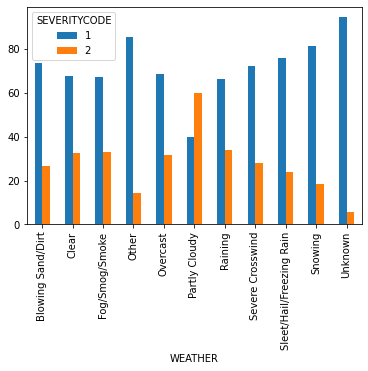

In [15]:
(pd.crosstab(index=acc_var['WEATHER'],
           columns= acc_var['SEVERITYCODE']).apply(lambda r: r/r.sum()*100, axis=1)).plot(kind='bar')

Viewing the numbers and the previous graph, I consider that "Weather" it is not relevant so I will not use it anymore for more depth analysis.

<AxesSubplot:xlabel='ROADCOND'>

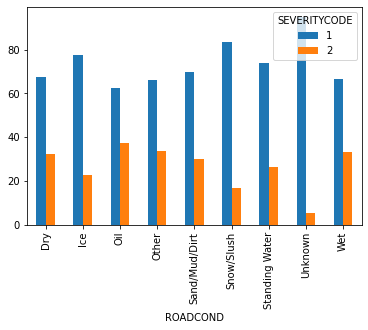

In [16]:
(pd.crosstab(index=acc_var['ROADCOND'],
           columns= acc_var['SEVERITYCODE']).apply(lambda r: r/r.sum()*100, axis=1)).plot(kind='bar')

Viewing the numbers and the previous graph, I consider that "ROADCOND" it is not relevant so I will not use it anymore for more depth analysis.

<AxesSubplot:xlabel='SPEEDING'>

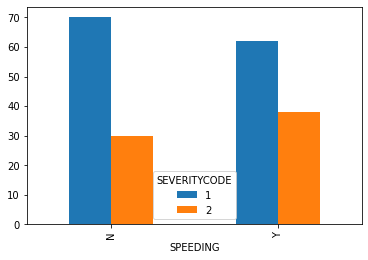

In [17]:
(pd.crosstab(index=acc_var['SPEEDING'],
           columns= acc_var['SEVERITYCODE']).apply(lambda r: r/r.sum()*100, axis=1)).plot(kind='bar')

Viewing the numbers and the previous graph, I consider that "Speeding" it is not relevant so I will not use it anymore for more depth analysis.

<AxesSubplot:xlabel='COLLISIONTYPE'>

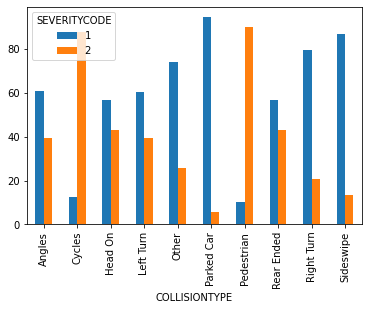

In [18]:
(pd.crosstab(index=acc_var['COLLISIONTYPE'],
           columns= acc_var['SEVERITYCODE']).apply(lambda r: r/r.sum()*100, axis=1)).plot(kind='bar')

<AxesSubplot:xlabel='ADDRTYPE'>

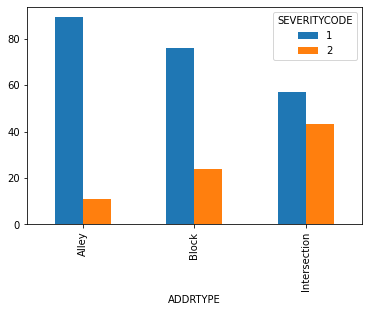

In [19]:
(pd.crosstab(index=acc_var['ADDRTYPE'],
           columns= acc_var['SEVERITYCODE']).apply(lambda r: r/r.sum()*100, axis=1)).plot(kind='bar')

<AxesSubplot:xlabel='LIGHTCOND'>

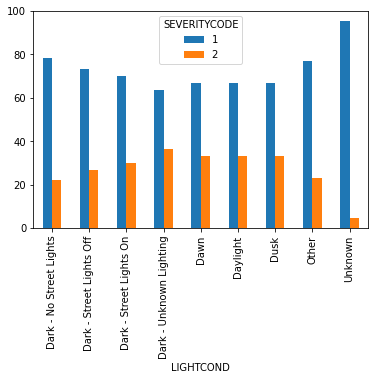

In [20]:
(pd.crosstab(index=acc_var['LIGHTCOND'],
           columns= acc_var['SEVERITYCODE']).apply(lambda r: r/r.sum()*100, axis=1)).plot(kind='bar')

Viewing the numbers and the previous graph, I consider that "LIGHTCOND" it is not relevant so I will not use it anymore for more depth analysis.

In [21]:
acc_var['PERSONCOUNT'].value_counts()

2     109553
3      34984
4      14389
1      11581
5       6560
0       5505
6       2695
7       1126
8        533
9        214
10       127
11        56
12        33
13        21
14        19
15        11
17        11
16         8
44         6
18         6
20         6
25         6
19         5
26         4
22         4
27         3
28         3
29         3
47         3
32         3
34         3
37         3
23         2
21         2
24         2
30         2
36         2
57         1
31         1
35         1
39         1
41         1
43         1
48         1
53         1
54         1
81         1
Name: PERSONCOUNT, dtype: int64

Let's organize and group the distribution of this variable "PERSONCOUNT" into serveral bins. 
The new variable with the bins I will call it "PC RANGE" and I will use it to make the tests. But I will return to the original variable "PERSON COUNT" to make the model because it is better having actual the numeric variable.

In [22]:
bins = [-1,5, 8, 10, 17, np.inf]
labels = ['0-5','6-8','8-10','10-17','+17']
#labels = [f'{i}+' if j==np.inf else f'{i}-{j}' for i, j in zip(bins, bins[1:])]

acc_var['PCRANGE'] = pd.cut(acc_var['PERSONCOUNT'], bins, labels=labels)
acc_var.groupby('PCRANGE')['SEVERITYCODE'].value_counts()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


PCRANGE  SEVERITYCODE
0-5      1               128289
         2                54283
6-8      2                 2272
         1                 2082
8-10     2                  202
         1                  139
10-17    2                   92
         1                   67
+17      1                   57
         2                   21
Name: SEVERITYCODE, dtype: int64

In [23]:
acc_var['PCRANGE'].value_counts()

0-5      182572
6-8        4354
8-10        341
10-17       159
+17          78
Name: PCRANGE, dtype: int64

<AxesSubplot:xlabel='PCRANGE'>

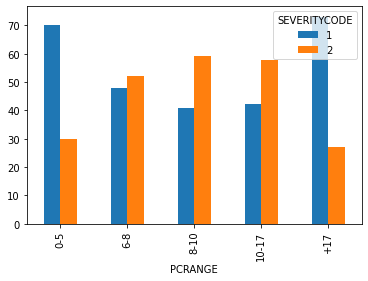

In [24]:
(pd.crosstab(index=acc_var['PCRANGE'],
           columns= acc_var['SEVERITYCODE']).apply(lambda r: r/r.sum()*100, axis=1)).plot(kind='bar')

In [25]:
acc_var_pcr= acc_var.groupby(["PCRANGE", "SEVERITYCODE"])["PCRANGE"].count().reset_index(name="COUNT")
acc_var_pcr

,PCRANGE,SEVERITYCODE,COUNT
0,0-5,1,128289
1,0-5,2,54283
2,6-8,1,2082
3,6-8,2,2272
4,8-10,1,139
5,8-10,2,202
6,10-17,1,67
7,10-17,2,92
8,+17,1,57
9,+17,2,21


In [26]:
acc_var_ct= acc_var.groupby(["COLLISIONTYPE", "SEVERITYCODE"])["COLLISIONTYPE"].count().reset_index(name="COUNT")
acc_var_ct

,COLLISIONTYPE,SEVERITYCODE,COUNT
0,Angles,1,20970
1,Angles,2,13585
2,Cycles,1,668
3,Cycles,2,4731
4,Head On,1,1142
5,Head On,2,869
6,Left Turn,1,8259
7,Left Turn,2,5400
8,Other,1,17375
9,Other,2,6065


Nice! I will my make the model only with the relevant variables and those which are meaningfull to predict the "SEVERITYCODE".
I will keep forward "ADDRTYPE", "COLLUSIONTYPE" and "PC RANGE".

Let's see again a basic view of my new clean dataset that I will use. I will analyze the distribution of each variable, the types, check if there are null values, etc.

In [27]:
df= acc_var[['SEVERITYCODE','ADDRTYPE','COLLISIONTYPE','PCRANGE']]
df.describe(include='all')

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,PCRANGE
count,187504.000000,187504,187504,187504
unique,NaN,3,10,5
top,NaN,Block,Parked Car,0-5
freq,NaN,123315,46679,182572
mean,1.303300,NaN,NaN,NaN
std,0.459685,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,1.000000,NaN,NaN,NaN
50%,1.000000,NaN,NaN,NaN
75%,2.000000,NaN,NaN,NaN


In [28]:
nullvalues = df.isnull()
nullvalues.head(5)

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,PCRANGE
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False


In [29]:
for column in nullvalues.columns.values.tolist():
    print(column)
    print (nullvalues[column].value_counts())
    print("")    

SEVERITYCODE
False    187504
Name: SEVERITYCODE, dtype: int64

ADDRTYPE
False    187504
Name: ADDRTYPE, dtype: int64

COLLISIONTYPE
False    187504
Name: COLLISIONTYPE, dtype: int64

PCRANGE
False    187504
Name: PCRANGE, dtype: int64



In [30]:
df.dtypes

SEVERITYCODE        int64
ADDRTYPE           object
COLLISIONTYPE      object
PCRANGE          category
dtype: object

In [31]:
df.shape

(187504, 4)

In [32]:
df['SEVERITYCODE'].value_counts()

1    130634
2     56870
Name: SEVERITYCODE, dtype: int64

In [33]:
df['COLLISIONTYPE'].value_counts()

Parked Car    46679
Angles        34555
Rear Ended    33794
Other         23440
Sideswipe     18442
Left Turn     13659
Pedestrian     6589
Cycles         5399
Right Turn     2936
Head On        2011
Name: COLLISIONTYPE, dtype: int64

In [34]:
df['PCRANGE'].value_counts()

0-5      182572
6-8        4354
8-10        341
10-17       159
+17          78
Name: PCRANGE, dtype: int64

In [35]:
df['ADDRTYPE'].value_counts()

Block           123315
Intersection     63447
Alley              742
Name: ADDRTYPE, dtype: int64

<AxesSubplot:xlabel='SEVERITYCODE', ylabel='count'>

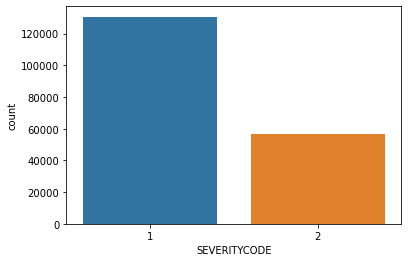

In [36]:
sns.countplot(x='SEVERITYCODE',data=df)

<AxesSubplot:xlabel='SEVERITYCODE', ylabel='count'>

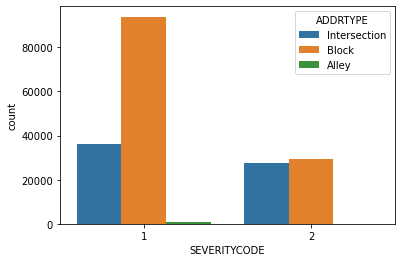

In [37]:
sns.countplot(x='SEVERITYCODE',hue='ADDRTYPE',data=df)

<AxesSubplot:xlabel='SEVERITYCODE', ylabel='count'>

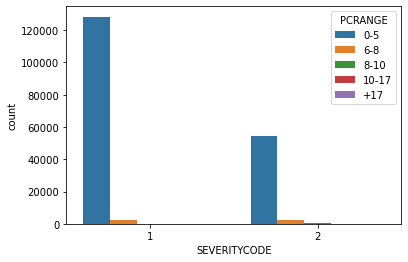

In [38]:
sns.countplot(x='SEVERITYCODE',hue='PCRANGE',data=df)

<AxesSubplot:xlabel='PCRANGE', ylabel='count'>

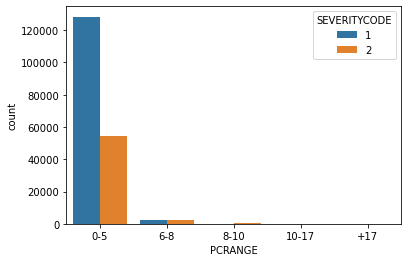

In [39]:
sns.countplot(x='PCRANGE',hue='SEVERITYCODE',data=df)

In [40]:
df.head(15)

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,PCRANGE
0,2,Intersection,Angles,0-5
1,1,Block,Sideswipe,0-5
2,1,Block,Parked Car,0-5
3,1,Block,Other,0-5
4,2,Intersection,Angles,0-5
5,1,Intersection,Angles,0-5
6,1,Intersection,Angles,0-5
7,2,Intersection,Cycles,0-5
8,1,Block,Parked Car,0-5
9,2,Intersection,Angles,0-5


In order to make my model, a logistic regression, I will have to replace every categorical variable into a numerical one. To doing that, I will converting every variable in a dummy dataframe and then concatenating it to the actual dataframe.


In [41]:
ADTYPE= pd.get_dummies(df['ADDRTYPE'])


In [42]:
df = pd.concat([df,ADTYPE],axis=1)
df

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,PCRANGE,Alley,Block,Intersection
0,2,Intersection,Angles,0-5,0,0,1
1,1,Block,Sideswipe,0-5,0,1,0
2,1,Block,Parked Car,0-5,0,1,0
3,1,Block,Other,0-5,0,1,0
4,2,Intersection,Angles,0-5,0,0,1
...,...,...,...,...,...,...,...
187499,2,Block,Head On,0-5,0,1,0
187500,1,Block,Rear Ended,0-5,0,1,0
187501,2,Intersection,Left Turn,0-5,0,0,1
187502,2,Intersection,Cycles,0-5,0,0,1


In [43]:
del df['ADDRTYPE']

In [44]:
df.head()

,SEVERITYCODE,COLLISIONTYPE,PCRANGE,Alley,Block,Intersection
0,2,Angles,0-5,0,0,1
1,1,Sideswipe,0-5,0,1,0
2,1,Parked Car,0-5,0,1,0
3,1,Other,0-5,0,1,0
4,2,Angles,0-5,0,0,1


In [45]:
COLTYPE= pd.get_dummies(df['COLLISIONTYPE'])
df = pd.concat([df,COLTYPE],axis=1)
df

,SEVERITYCODE,COLLISIONTYPE,PCRANGE,Alley,Block,Intersection,Angles,Cycles,Head On,Left Turn,Other,Parked Car,Pedestrian,Rear Ended,Right Turn,Sideswipe
0,2,Angles,0-5,0,0,1,1,0,0,0,0,0,0,0,0,0
1,1,Sideswipe,0-5,0,1,0,0,0,0,0,0,0,0,0,0,1
2,1,Parked Car,0-5,0,1,0,0,0,0,0,0,1,0,0,0,0
3,1,Other,0-5,0,1,0,0,0,0,0,1,0,0,0,0,0
4,2,Angles,0-5,0,0,1,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187499,2,Head On,0-5,0,1,0,0,0,1,0,0,0,0,0,0,0
187500,1,Rear Ended,0-5,0,1,0,0,0,0,0,0,0,0,1,0,0
187501,2,Left Turn,0-5,0,0,1,0,0,0,1,0,0,0,0,0,0
187502,2,Cycles,0-5,0,0,1,0,1,0,0,0,0,0,0,0,0


In [46]:
del df['COLLISIONTYPE']
df

,SEVERITYCODE,PCRANGE,Alley,Block,Intersection,Angles,Cycles,Head On,Left Turn,Other,Parked Car,Pedestrian,Rear Ended,Right Turn,Sideswipe
0,2,0-5,0,0,1,1,0,0,0,0,0,0,0,0,0
1,1,0-5,0,1,0,0,0,0,0,0,0,0,0,0,1
2,1,0-5,0,1,0,0,0,0,0,0,1,0,0,0,0
3,1,0-5,0,1,0,0,0,0,0,1,0,0,0,0,0
4,2,0-5,0,0,1,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187499,2,0-5,0,1,0,0,0,1,0,0,0,0,0,0,0
187500,1,0-5,0,1,0,0,0,0,0,0,0,0,1,0,0
187501,2,0-5,0,0,1,0,0,0,1,0,0,0,0,0,0
187502,2,0-5,0,0,1,0,1,0,0,0,0,0,0,0,0


In [47]:
df.dtypes

SEVERITYCODE       int64
PCRANGE         category
Alley              uint8
Block              uint8
Intersection       uint8
Angles             uint8
Cycles             uint8
Head On            uint8
Left Turn          uint8
Other              uint8
Parked Car         uint8
Pedestrian         uint8
Rear Ended         uint8
Right Turn         uint8
Sideswipe          uint8
dtype: object

Now, I have the variable "PC RANGE" that it is not numeric, it is a Category. In order to make the model, how I said it before, I will delete this variable and replace it for "PERSON COUNT"

In [48]:
df = pd.concat([df,acc_var['PERSONCOUNT']],axis=1)

In [49]:
del df['PCRANGE']
df.head()

,SEVERITYCODE,Alley,Block,Intersection,Angles,Cycles,Head On,Left Turn,Other,Parked Car,Pedestrian,Rear Ended,Right Turn,Sideswipe,PERSONCOUNT
0,2,0,0,1,1,0,0,0,0,0,0,0,0,0,2
1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,2
2,1,0,1,0,0,0,0,0,0,1,0,0,0,0,4
3,1,0,1,0,0,0,0,0,1,0,0,0,0,0,3
4,2,0,0,1,1,0,0,0,0,0,0,0,0,0,2


In order to make easy my model, I will call "X" to all the independant variables and "Y" the dependant variable.

In [50]:
X = np.asarray(df[['PERSONCOUNT', 'Alley', 'Block', 'Intersection', 'Angles', 'Cycles', 'Head On','Left Turn','Other','Parked Car','Pedestrian','Rear Ended','Right Turn','Sideswipe']])

In [51]:
Y = df['SEVERITYCODE']

I will make my logistic regression with diferent solvers and different size of train and test set to later can perform a comparison and define which is the best.

I will use the train_test_split function to separate my dataset in 80% of the size in a train set and the remainly 20% in a test set. 

For first instance, I will make it with the liblinear solver

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape, Y_test.shape)

Train set: (150003, 14) (150003,)
Test set: (37501, 14) (37501,)


In [53]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,Y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [54]:
yhat = LR.predict(X_test)
yhat

array([1, 1, 1, ..., 1, 1, 1])

In [55]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.63112811, 0.36887189],
       [0.5852245 , 0.4147755 ],
       [0.94108987, 0.05891013],
       ...,
       [0.67584882, 0.32415118],
       [0.94108987, 0.05891013],
       [0.77405284, 0.22594716]])

## Results & Discussion <a name="Methodology"></a>

In [56]:
jaccard_similarity_score(Y_test, yhat)

0.7538998960027733

In [57]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(Y_test, yhat, labels=[1,0]))

[[25189     0]
 [    0     0]]


Confusion matrix, without normalization
[[25189     0]
 [    0     0]]


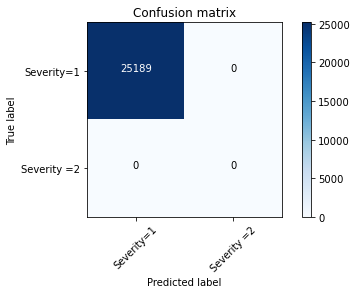

In [58]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Severity=1','Severity =2'],normalize= False,  title='Confusion matrix')

In [59]:
print (classification_report(Y_test, yhat))

              precision    recall  f1-score   support

           1       0.75      0.96      0.85     26196
           2       0.75      0.27      0.40     11305

   micro avg       0.75      0.75      0.75     37501
   macro avg       0.75      0.62      0.62     37501
weighted avg       0.75      0.75      0.71     37501



In [60]:
log_loss(Y_test, yhat_prob)

0.4888385000789111

Lets make the same model but normalizing the variables first. Then I can compare the results

In [61]:
X2 = preprocessing.StandardScaler().fit(X).transform(X)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [62]:
from sklearn.model_selection import train_test_split
X2_train, X2_test, Y2_train, Y2_test = train_test_split( X2, Y, test_size=0.2, random_state=4)
print ('Train set:', X2_train.shape,  Y2_train.shape)
print ('Test set:', X2_test.shape,  Y2_test.shape)

Train set: (150003, 14) (150003,)
Test set: (37501, 14) (37501,)


In [63]:
LR2 = LogisticRegression(C=0.01, solver='liblinear').fit(X2_train,Y2_train)
LR2

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [64]:
yhat2 = LR2.predict(X2_test)
yhat2

array([1, 1, 1, ..., 1, 1, 1])

In [65]:
yhat_prob2 = LR2.predict_proba(X2_test)
yhat_prob2

array([[0.62, 0.38],
       [0.59, 0.41],
       [0.95, 0.05],
       ...,
       [0.67, 0.33],
       [0.95, 0.05],
       [0.77, 0.23]])

In [66]:
jaccard_similarity_score(Y2_test, yhat2)

0.7538998960027733

In [67]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, with normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(Y2_test, yhat2, labels=[1,0]))

[[25183     0]
 [    0     0]]


In [68]:
print (classification_report(Y2_test, yhat2))

              precision    recall  f1-score   support

           1       0.75      0.96      0.85     26196
           2       0.75      0.27      0.40     11305

   micro avg       0.75      0.75      0.75     37501
   macro avg       0.75      0.62      0.62     37501
weighted avg       0.75      0.75      0.71     37501



In [69]:
log_loss(Y2_test, yhat_prob2)

0.48765894196432175

Now I will make the same procedure but using the "saga" solver to see if makes a difference and see if I can have a better results

In [70]:
X3_train, X3_test, Y3_train, Y3_test = train_test_split( X, Y, test_size=0.15, random_state=4)
print ('Train set:', X3_train.shape,  Y3_train.shape)
print ('Test set:', X3_test.shape, Y3_test.shape)

Train set: (159378, 14) (159378,)
Test set: (28126, 14) (28126,)


In [71]:
LR3 = LogisticRegression(C=0.01, solver='saga').fit(X3_train,Y3_train)
LR3

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [72]:
yhat3 = LR3.predict(X3_test)
yhat3

array([1, 1, 1, ..., 2, 1, 1])

In [73]:
yhat_prob3 = LR3.predict_proba(X3_test)
yhat_prob3

array([[0.63, 0.37],
       [0.59, 0.41],
       [0.94, 0.06],
       ...,
       [0.47, 0.53],
       [0.94, 0.06],
       [0.62, 0.38]])

In [74]:
jaccard_similarity_score(Y3_test, yhat3)

0.7526487947095214

In [75]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, with normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(Y3_test, yhat3, labels=[1,0]))

[[18811     0]
 [    0     0]]


In [76]:
print (classification_report(Y3_test, yhat3))

              precision    recall  f1-score   support

           1       0.75      0.96      0.84     19571
           2       0.76      0.28      0.40      8555

   micro avg       0.75      0.75      0.75     28126
   macro avg       0.75      0.62      0.62     28126
weighted avg       0.75      0.75      0.71     28126



In [77]:
log_loss(Y3_test, yhat_prob3)

0.48830296402509155

## Conclusion <a name="Methodology"></a>

Let's compare the 3 models by the Jaccard similarity Score


In [78]:
J1=jaccard_similarity_score(Y_test, yhat)
J2=jaccard_similarity_score(Y2_test, yhat2)
J3=jaccard_similarity_score(Y3_test, yhat3)



In [79]:
print("J1 =",J1)
print("J2 =",J2)
print("J3 =",J3)

J1 = 0.7538998960027733
J2 = 0.7538998960027733
J3 = 0.7526487947095214


Let's compare the 3 models by the Log Loss

In [80]:
Logloss1= log_loss(Y_test, yhat_prob)
Logloss2= log_loss(Y2_test, yhat_prob2)
Logloss3= log_loss(Y3_test, yhat_prob3)

In [81]:
print("Logloss1 =",Logloss1)
print("Logloss2 =",Logloss2)
print("Logloss3 =",Logloss3)

Logloss1 = 0.4888385000789111
Logloss2 = 0.48765894196432175
Logloss3 = 0.48830296402509155


After this comparison, although the 3 models are very similar and their results too, I can define that the second model is the best.
So this one is the one that I am going to use to predict the SEVERITY CODE =)